In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from project_helpers import *

Extracting data

In [2]:
from project_helpers import get_dataset_info

K, img_names, init_pair, pixel_threshold = get_dataset_info(1)
  
img1 = (plt.imread('data/1/kronan1.jpg') * 255).astype('uint8')
img2 = (plt.imread('data/1/kronan2.jpg') * 255).astype('uint8')

print(get_dataset_info(1))
print(img_names)

(array([[2.48914286e+03, 0.00000000e+00, 9.68000000e+02],
       [0.00000000e+00, 2.48914286e+03, 6.48000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), ['data/1/kronan1.JPG', 'data/1/kronan2.JPG'], [0, 1], 1.0)
['data/1/kronan1.JPG', 'data/1/kronan2.JPG']


In [3]:
def read_images(img_names):
  images = []
  for name in img_names:
    images.append((plt.imread(name) * 255).astype('uint8'))
  return images

Getting SIFT points and descriptors

In [4]:
from cv2 import SIFT_create, cvtColor, COLOR_RGB2GRAY, FlannBasedMatcher, drawMatchesKnn
rgb2gray = lambda img: cvtColor(img, COLOR_RGB2GRAY)
sift = SIFT_create(contrastThreshold=0.02, edgeThreshold=10, nOctaveLayers=3)

# We detect keypoints and simultaneously describe them using SIFT
kp1, des1 = sift.detectAndCompute(rgb2gray(img1),None)
kp2, des2 = sift.detectAndCompute(rgb2gray(img2),None)

print(len(kp1))

51617


In [5]:
def extract_sift_features(images):
  keypoints = []
  descriptors = []
  for image in images:
    kp, des = sift.detectAndCompute(rgb2gray(image),None)
    keypoints.append(kp)
    descriptors.append(des)
    #print(len(kp))
  return keypoints, descriptors

#images = read_images(img_names)
#extract_sift_features(images)

Matching sift points and descriptors

In [6]:
# We use a k-NN-like system to find the most similar descriptions
all_matches = FlannBasedMatcher().knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m,n in all_matches:
    if m.distance < 0.75*n.distance:
        good_matches.append([m])
        
# Supplied code for extracting numpy arrays from matching keypoints
# Note, x1 and x2 are in homogenous coordinates after this
x1 = np.array([[kp1[match[0].queryIdx].pt[0], kp1[match[0].queryIdx].pt[1]] for match in good_matches])
x2 = np.array([[kp2[match[0].trainIdx].pt[0], kp2[match[0].trainIdx].pt[1]] for match in good_matches])
x1_homo = np.vstack((x1.T, np.ones(x1.shape[0])))
x2_homo = np.vstack((x2.T, np.ones(x2.shape[0])))
xu = np.array([x1, x2])

x1_n = np.linalg.inv(K) @ x1
x2_n = np.linalg.inv(K) @ x2
xn = [x1_n, x2_n]

print('matches', len(all_matches))
print('good matches', len(good_matches))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 18187 is different from 3)

In [20]:
def match_sift_features(keypoints, descriptors):
  keypoint_pairs = []
  
  for i in range(len(keypoints)-1):
    all_matches = FlannBasedMatcher().knnMatch(descriptors[i], descriptors[i+1], k=2)
    good_matches = []
    for m,n in all_matches:
        if m.distance < 0.75*n.distance:
            good_matches.append([m])
            
    x1 = np.array([[kp1[match[0].queryIdx].pt[0], kp1[match[0].queryIdx].pt[1]] for match in good_matches])
    x2 = np.array([[kp2[match[0].trainIdx].pt[0], kp2[match[0].trainIdx].pt[1]] for match in good_matches])
    x1_homo = np.vstack((x1.T, np.ones(x1.shape[0])))
    x2_homo = np.vstack((x2.T, np.ones(x2.shape[0])))
    
    x1_n = np.linalg.inv(K) @ x1_homo
    x2_n = np.linalg.inv(K) @ x2_homo
    keypoint_pairs.append([x1_n,x2_n])
    
  return keypoint_pairs

In [ ]:
def img_pts(img1, kp1, des1, img2,K):
  kp2, des2 = sift.detectAndCompute(rgb2gray(img2),None)
  
  all_matches = FlannBasedMatcher().knnMatch(des1, des2, k=2)
  
  good_matches = []
  for m,n in all_matches:
      if m.distance < 0.75*n.distance:
          good_matches.append([m])
          
  x1 = np.array([[kp1[match[0].queryIdx].pt[0], kp1[match[0].queryIdx].pt[1]] for match in good_matches])
  x2 = np.array([[kp2[match[0].trainIdx].pt[0], kp2[match[0].trainIdx].pt[1]] for match in good_matches])
  x1 = np.vstack((x1.T, np.ones(x1.shape[0])))
  x2 = np.vstack((x2.T, np.ones(x2.shape[0])))
  
  return x1, x2, kp2, des2

plot 10 random

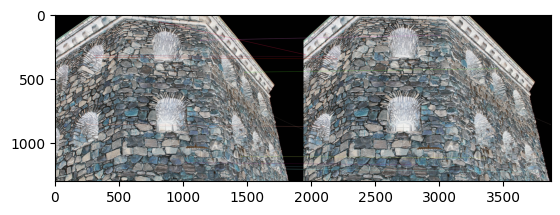

(<matplotlib.image.AxesImage at 0x1e3be46dfd0>, None)

In [ ]:
idx = np.random.choice(len(matches), size=10, replace=False)
matches_array = np.array(matches)
selected_matches = matches_array[idx]

plt.figure()
img3 = drawMatchesKnn(img1,kp1,img2,kp2,selected_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3,),plt.show()

Estimating E robustly and extracting P fro E

In [ ]:
threshold_px = 2
eps = threshold_px / K[0,0]
x1_k = np.linalg.inv(K) @ x1
x2_k = np.linalg.inv(K) @ x2

E_robust, inliers, errs, iters = estimate_E_robust(x1_k, x2_k, eps)


x1_inliers = inliers[:3]
x2_inliers = inliers[3:]

# Compute the essential matrix based on the keypoint matches we just computed between the two images

P2_extract = extract_P_from_E(E_robust)

P1_k = np.array([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0]])

best_i = None
best_count = 0

for i in range(4):
    count = count_points_in_front(P1_k, P2_extract[i], x1_k, x2_k)
    if count > best_count:
        best_count = count
        best_i = i
    print('count',i,count)
    
print('best count', best_i)

print('inlier shape', inliers.shape)
print('x1_inliers shape', x1_inliers.shape)

P2 = P2_extract[best_i]

inliers 16053
count 0 18353
count 1 86
count 2 0
count 3 0
best count 0
inlier shape (6, 16053)
x1_inliers shape (3, 16053)
0


In [ ]:
def get_camera_matrices(keypoint_pairs):
  threshold_px = 2
  eps = threshold_px / K[0,0]
  
  camera_matrices = []
  keypoint_pairs_inlier = []
  
  P1_k = np.array([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0]])
  
  for pair in keypoint_pairs:
    x1, x2 = pair
    x1_k = np.linalg.inv(K) @ x1
    x2_k = np.linalg.inv(K) @ x2
    
    E_robust, inliers, errs, iters = estimate_E_robust(x1_k, x2_k, eps)
    #print(E_robust)
    x1_inliers = inliers[:3]
    x2_inliers = inliers[3:]
    keypoint_pairs_inlier.append([x1_inliers,x2_inliers])
    
    P2_extract = extract_P_from_E(E_robust)
    
    best_i = None
    best_count = 0

    for i in range(4):
        count = count_points_in_front(P1_k, P2_extract[i], x1_k, x2_k)
        if count > best_count:
            best_count = count
            best_i = i
    best_p2 = P2_extract[best_i]
    camera_matrices.append(best_p2)
    
  return camera_matrices, keypoint_pairs_inlier

In [ ]:
def chain_camera_matrices(camera_matrices):
  C1 = 
  for i in range(len(camera_matrices)-1)
  return camera_matrix_chain

SyntaxError: invalid syntax (654730264.py, line 2)

In [ ]:
def get_RT(P1,x1,x2):
    threshold_px = 2
    eps = threshold_px / K[0,0]
    x1_k = np.linalg.inv(K) @ x1_inliers
    x2_k = np.linalg.inv(K) @ x2
    E_robust, inliers, errs, iters = estimate_E_robust(x1_k, x2_k, eps)
    x1_inliers = inliers[:2]
    x2_inliers = inliers[2:]

    # Compute the essential matrix based on the keypoint matches we just computed between the two images

    # Print the number of inliers

    P2_extract = extract_P_from_E(E_robust)  

    best_i = None
    best_count = 0

    for i in range(4):
        count = count_points_in_front(P1_k, P2_extract[i], x1_k, x2_k)
        if count > best_count:
            best_count = count
            best_i = i
        print(count)
        
    print(best_i)

    R = P2[:,:3]
    T = P2[:,3]
    return R, T

Calculate R, T from P

In [ ]:
R = P2[:,:3]
T = P2[:,3]

print(R)
print(T)

[[ 0.9939519   0.02887019  0.10595348]
 [-0.03082229  0.99938313  0.01683282]
 [-0.10540216 -0.01999674  0.9942286 ]]
[-0.92108086 -0.13969288 -0.36345006]


(3, 18485)
(3, 18485)
(3, 4)
(3, 4)


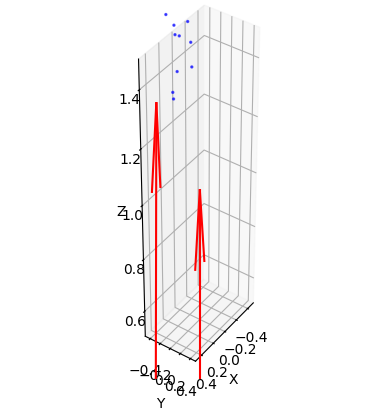

In [ ]:
print(x1_k.shape)
print(x2_k.shape)
print(P1_k.shape)
print(P2.shape)

n = x1.shape[1] 
points_3D = np.zeros((4,n))
for i in range(n):
  points_3D[:,i] = triangulate_3D_point_DLT(x1_k[:,i],x2_k[:,i],P1_k,P2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D[0,:], points_3D[1,:], points_3D[2,:], s=2, c='b')
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(40, 35)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(0.5, 1.5)


plot_camera(K @ P1_k, 1, ax)
plot_camera(K @ P2, 1, ax)

plt.show()

In [28]:
def run_sfm(dataset_num):
  K, img_names, init_pair, pixel_threshold = get_dataset_info(dataset_num)
  
  #print('K', K, '\n image names', img_names, init_pair, pixel_threshold)
  
  images = read_images(img_names)
  
  print('number of images', len(images))
  print('image shape', images[0].shape)  
  
  keypoints, descriptors = extract_sift_features(images)
  
  keypoint_pairs = match_sift_features(keypoints, descriptors)
  print(len(keypoint_pairs))
  
  camera_matrices, keypoint_pairs_inlier = get_camera_matrices(keypoint_pairs)
  
  camera_matrices_chained = chain_camera_matrices(camera_matrices)
  
  # kp1, des1 = sift.detectAndCompute(rgb2gray(images[0]),None)
  # kpts = [kp1]
  # dess = [des1]
  # cam_mats_abs = [cam_mats[0]]
  
  # for i in range(len(images)-1):
  #   x1, x2, kpt2, des2 = img_pts(images[i], kpts[i], dess[i], images[i+1], K)
  #   kpts.append(kp2)
  #   dess.append(des2)
  #   dess = [des1]
  #   R, T = get_RT(cam_mats[i],x1,x2)
  #   cam_mats.append([R,T])
  #   Ri_plus = cam_mats[i][0] @ cam_mats[i+1][0]
  #   Ti_plus = cam_mats[i][1] + cam_mats[i+1][1]
  #   cam_mats_abs.append([Ri_plus,Ti_plus])
    
  # return cam_mats, cam_mats_abs

run_sfm(2)

number of images 9
image shape (1296, 1936, 3)
8
inliers 14732
[[-0.77156849 -0.3553317  -0.39279777]
 [-0.35567171  0.89927377  0.09645428]
 [-0.39264241  0.09568414 -0.12770564]]
inliers 15923
[[-0.75612606 -0.38563298 -0.39444382]
 [-0.38522909  0.88827036  0.08122813]
 [-0.39464266  0.08213337 -0.13214481]]
inliers 15234
[[ 0.76627847  0.36630058  0.39329124]
 [ 0.36575008 -0.8955499  -0.09044601]
 [ 0.39355049 -0.09168773  0.12927238]]
inliers 15322
[[ 0.77198001  0.35475738  0.39260768]
 [ 0.35459239 -0.89957782 -0.09622685]
 [ 0.39269033 -0.0965957   0.12759789]]
inliers 15603
[[ 0.75590175  0.38589995  0.39448905]
 [ 0.38583362 -0.88816952 -0.08120389]
 [ 0.39452911 -0.08134758  0.13226778]]
inliers 15572
[[-0.7534096  -0.39040216 -0.39480316]
 [-0.39055161  0.88631942  0.07928704]
 [-0.3947319   0.07895051 -0.13290989]]
inliers 15350
[[ 0.75427463  0.38900766  0.39458517]
 [ 0.38875949 -0.88699074 -0.07951483]
 [ 0.39473279 -0.08005404  0.13271629]]
inliers 14441
[[ 0.75233918

NameError: name 'chain_camera_matrices' is not defined